1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.
2. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.
3. Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы.
4. (опция). Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=13)

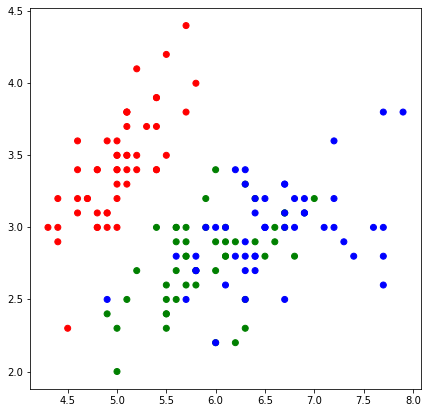

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [5]:
class KNN():
    
    def __init__(self, X_train, y_train, X_test, y_test, k=3, weight=None, target_class=1):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.k = k
        self.weight = weight
        self.target_class = target_class
        
    def e_metrics(self, x1, x2):
        
        distance = 0
        for i in range(len(x1)):
            distance += np.square(x1[i] - x2[i])

        return np.sqrt(distance)
    
    def predict(self, X_test_=True, pr_metric=False, plot=False):
        
        if isinstance(X_test_, bool):
            X_test = self.X_test
        else:
            X_test = X_test_
        answers = []
        for x in X_test:
            test_distances = []

            for i in range(len(self.X_train)):

                # расчет расстояния от классифицируемого объекта до
                # объекта обучающей выборки
                distance = self.e_metrics(x, self.X_train[i])

                # Записываем в список значение расстояния и ответа на объекте обучающей выборки
                test_distances.append((distance, self.y_train[i]))

            # создаем словарь со всеми возможными классами
            classes = {class_item: 0 for class_item in set(self.y_train)}

            # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
            
            for d, i in zip(sorted(test_distances)[0:self.k], range(1, len(sorted(test_distances)[0:self.k]) + 1)):
                
                if self.weight == None:
                    classes[d[1]] += 1
                elif self.weight == 'i':
                    classes[d[1]] += 0.9 ** i
                elif self.weight == 'distance':
                    classes[d[1]] += 0.9 ** d[0]

            # Записываем в список ответов наиболее часто встречающийся класс
            answers.append(sorted(classes, key=classes.get)[-1])
        answers = np.array(answers)
        
        if plot == True:    
            self.get_graph(self.X_train, self.y_train, self.k)
        if pr_metric == True:    
            self.calc_accuracy(answers, self.y_test)
#             self.calc_precision(answers, self.y_test)
#             self.calc_recall(answers, self.y_test)
            self.calc_f_score(answers, self.y_test)
        return answers
    
    def accuracy(self, y_pred):
        print(f'Точность алгоритма при k = {self.k}: {(sum(y_pred == self.y_test) / len(self.y_test)):.3f}')
        
    def get_graph(self, X_train, y_train, k):
        cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

        h = .02

        # Расчет пределов графика
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Получим предсказания для всех точек
        Z = self.predict(X_test_=np.c_[xx.ravel(), yy.ravel()])

        # Построим график
        Z = np.array(Z).reshape(xx.shape)
        plt.figure(figsize=(7,7))
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Добавим на график обучающую выборку
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"Трехклассовая kNN классификация при k = {k}")
        plt.show()
        
    
    def calc_accuracy(self,y_pred, y):
        accuracy = 100.0 - np.mean(np.abs(y_pred - y)*100.0)
        print(f'Accuracy: {accuracy}')
        
        return accuracy
    
    
    def matrix_err(self,y_pred, y):
        tp = np.count_nonzero((y_pred == y) & (y_pred == self.target_class))
        tn = np.count_nonzero((y_pred == y) & (y_pred != self.target_class))
        fp = np.count_nonzero((y_pred != y) & (y_pred == self.target_class))
        fn = np.count_nonzero((y_pred != y) & (y_pred != self.target_class))
        print('TP     FP\nFN     TN')
        print(np.array([[tp, fp], [fn, tn]]))
        
        return tp, tn, fp, fn
    
    
    def calc_precision(self,y_pred, y):
        tp, tn, fp, fn = self.matrix_err(y_pred, y)
        precision = tp / (tp + fp)
        print(f'Precision: {precision}')
        
        return precision
    
    
    def calc_recall(self,y_pred, y):
        tp, tn, fp, fn = self.matrix_err(y_pred, y)
        recall = tp / (tp + fn)
        print(f'Recall: {recall}')
        
        return recall
    
    
    def calc_f_score(self,y_pred, y, beta=1):
        tp, tn, fp, fn = self.matrix_err(y_pred, y)
        precision = self.calc_precision(y_pred, y)
        recall = self.calc_recall(y_pred, y)
        f_score = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)
        print(f'F-score: {f_score}')
        return f_score


In [6]:
def get_graph(self, X_train, y_train, k):
        cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

        h = .02

        # Расчет пределов графика
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Получим предсказания для всех точек
        
        Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

        # Построим график
        Z = np.array(Z).reshape(xx.shape)
        plt.figure(figsize=(7,7))
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Добавим на график обучающую выборку
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"Трехклассовая kNN классификация при k = {k}")

        plt.show()

<ipython-input-5-d62f8561e735>:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


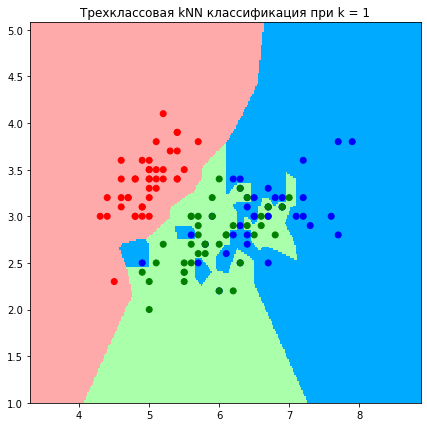

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


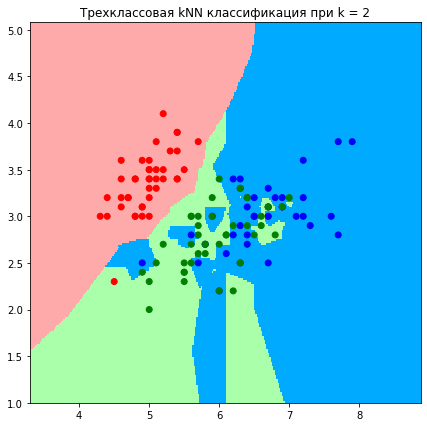

Accuracy: 90.0
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
Precision: 0.7272727272727273
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
Recall: 1.0
F-score: 0.8421052631578948


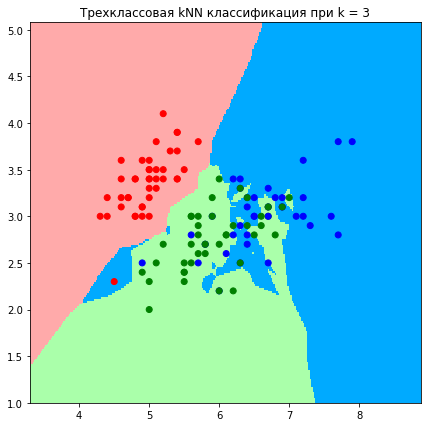

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


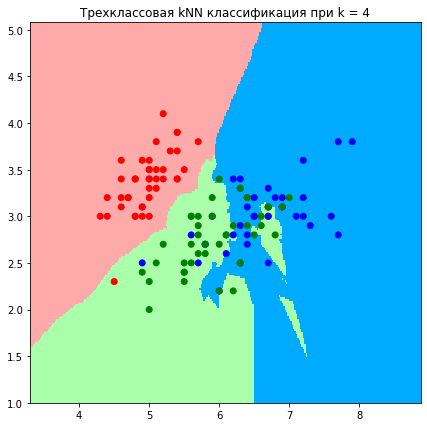

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


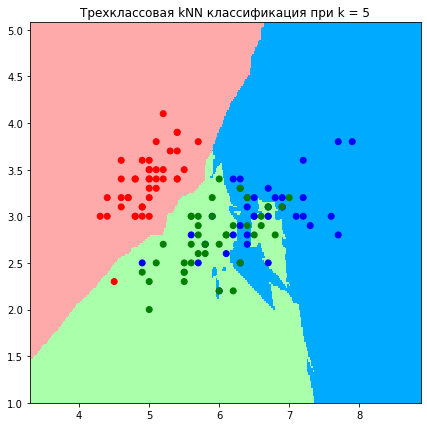

Accuracy: 80.0
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
Precision: 0.5714285714285714
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
Recall: 1.0
F-score: 0.7272727272727273


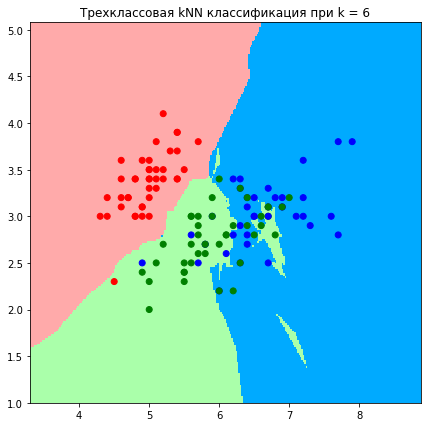

Accuracy: 80.0
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Precision: 0.5833333333333334
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Recall: 0.875
F-score: 0.7000000000000001


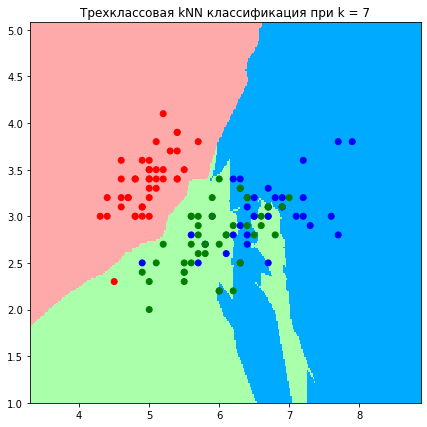

Accuracy: 76.66666666666667
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
Precision: 0.5384615384615384
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
Recall: 0.875
F-score: 0.6666666666666667


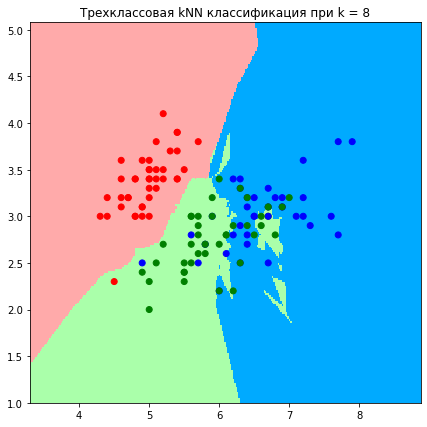

Accuracy: 80.0
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Precision: 0.5833333333333334
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Recall: 0.875
F-score: 0.7000000000000001


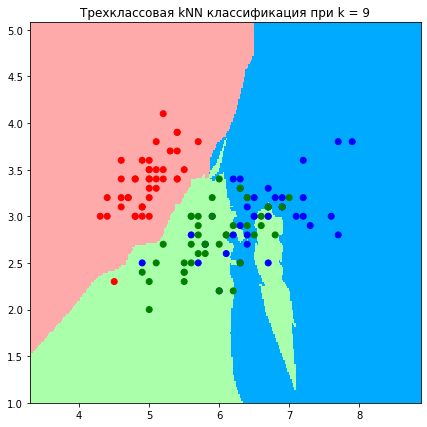

Accuracy: 73.33333333333333
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
Precision: 0.5
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
Recall: 0.875
F-score: 0.6363636363636364


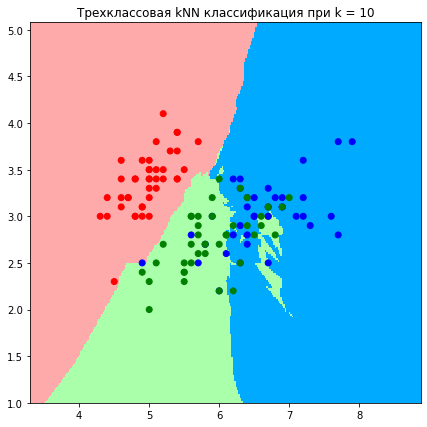

Accuracy: 80.0
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Precision: 0.5833333333333334
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Recall: 0.875
F-score: 0.7000000000000001


In [7]:
for k_ in range(1, 11):
    knn = KNN(X_train, y_train, X_test, y_test, k=k_)
    y_pred = knn.predict(pr_metric=True, plot=True)

<ipython-input-5-d62f8561e735>:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


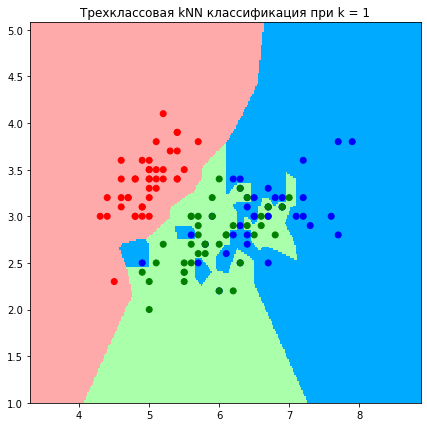

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


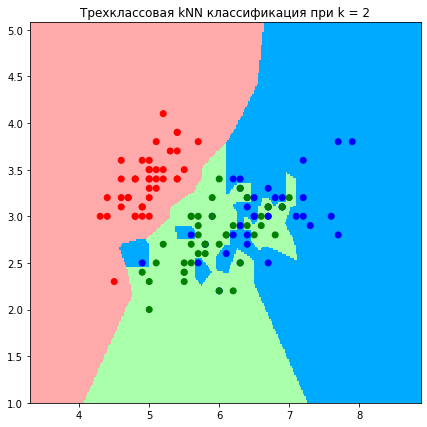

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


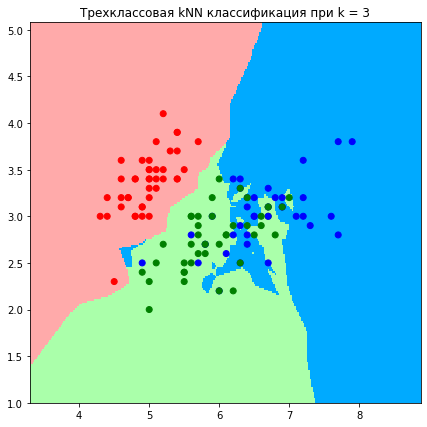

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


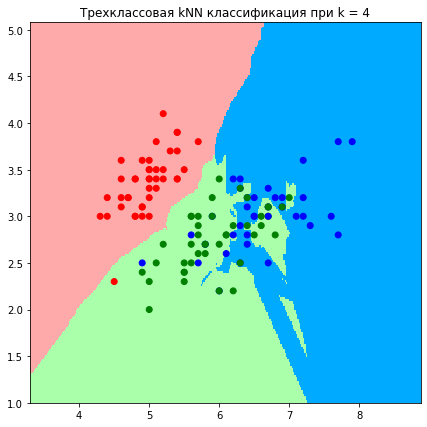

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


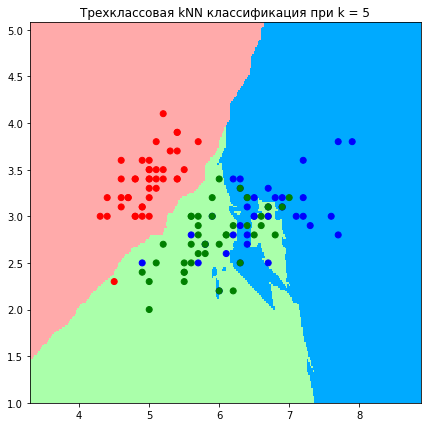

Accuracy: 80.0
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
Precision: 0.5714285714285714
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
Recall: 1.0
F-score: 0.7272727272727273


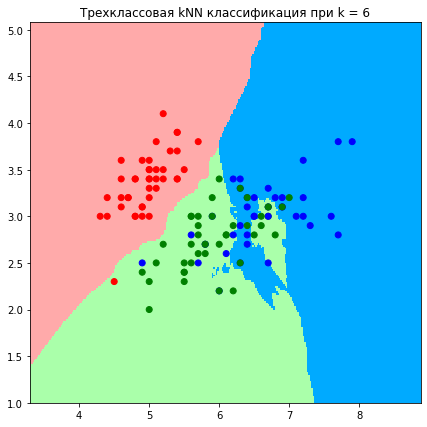

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


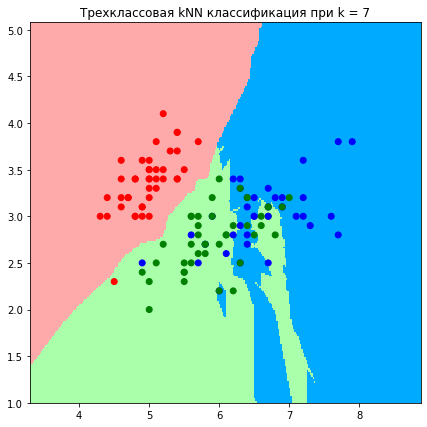

Accuracy: 80.0
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
Precision: 0.5714285714285714
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
Recall: 1.0
F-score: 0.7272727272727273


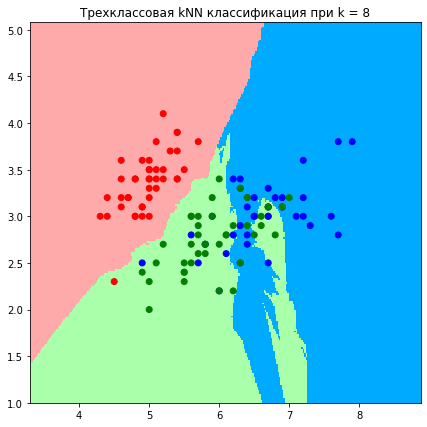

Accuracy: 76.66666666666667
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
Precision: 0.5384615384615384
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
Recall: 0.875
F-score: 0.6666666666666667


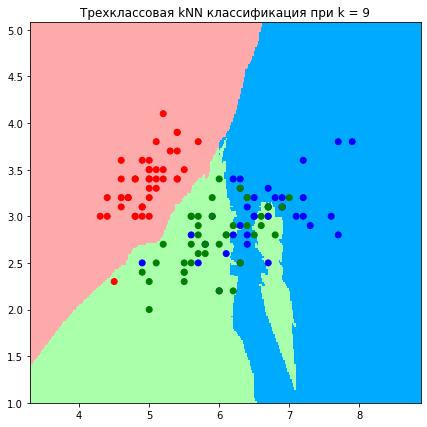

Accuracy: 76.66666666666667
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
Precision: 0.5384615384615384
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
Recall: 0.875
F-score: 0.6666666666666667


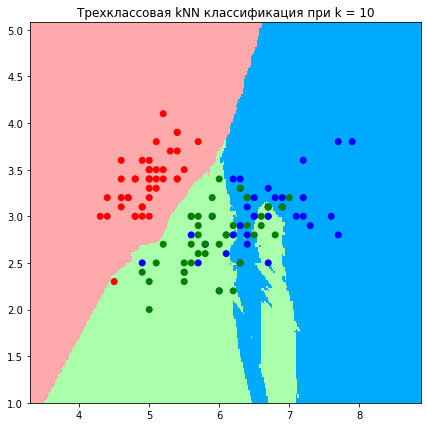

Accuracy: 80.0
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Precision: 0.5833333333333334
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Recall: 0.875
F-score: 0.7000000000000001


In [8]:
for k_ in range(1, 11):
    knn = KNN(X_train, y_train, X_test, y_test, k=k_, weight='i')
    y_pred = knn.predict(pr_metric=True, plot=True)

<ipython-input-5-d62f8561e735>:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


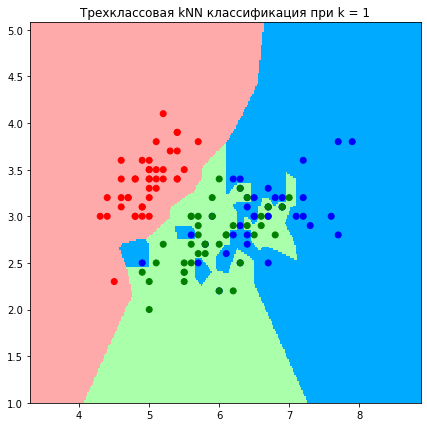

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


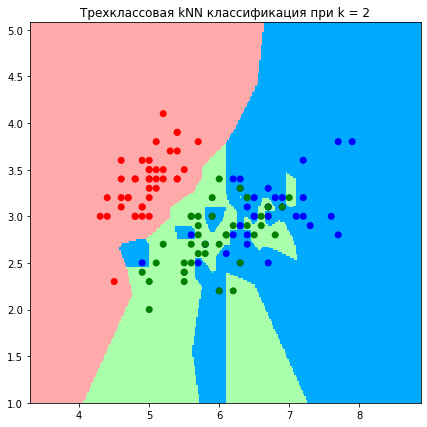

Accuracy: 90.0
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
Precision: 0.7272727272727273
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
Recall: 1.0
F-score: 0.8421052631578948


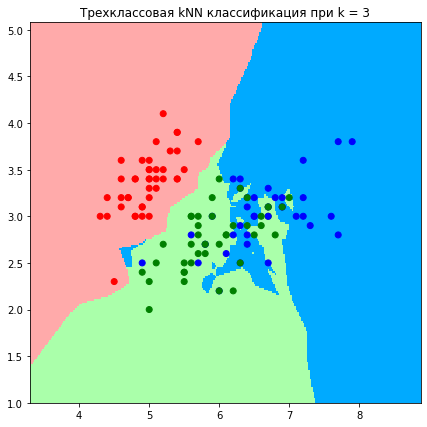

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


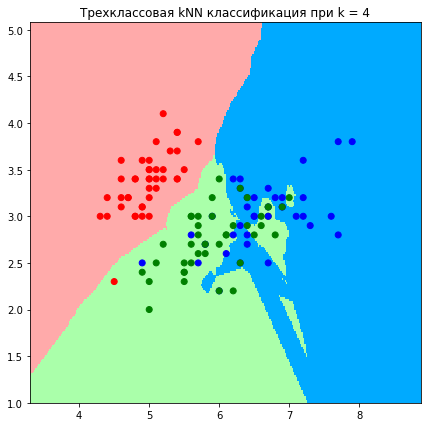

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


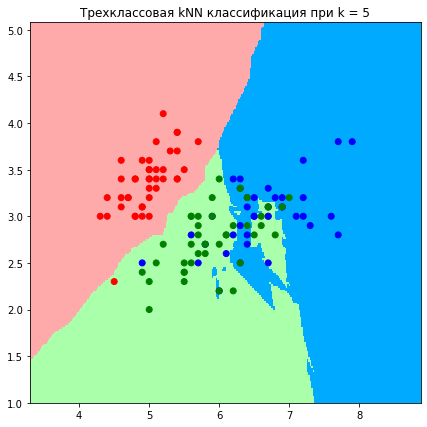

Accuracy: 80.0
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
Precision: 0.5714285714285714
TP     FP
FN     TN
[[ 8  6]
 [ 0 16]]
Recall: 1.0
F-score: 0.7272727272727273


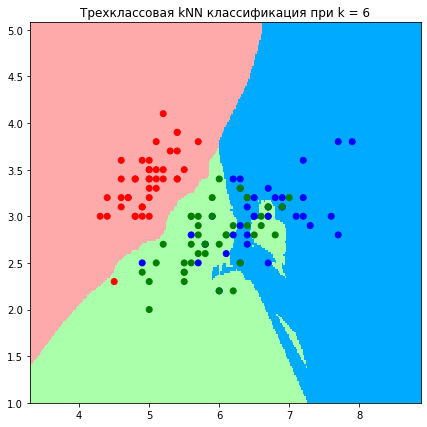

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


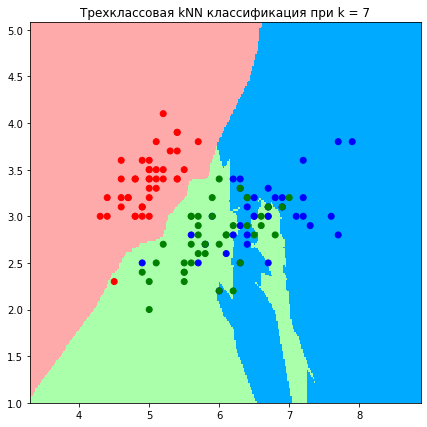

Accuracy: 76.66666666666667
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
Precision: 0.5384615384615384
TP     FP
FN     TN
[[ 7  6]
 [ 1 16]]
Recall: 0.875
F-score: 0.6666666666666667


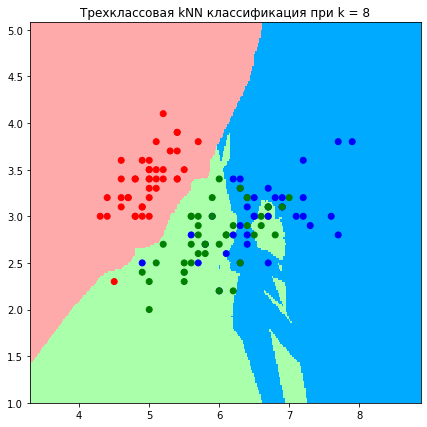

Accuracy: 80.0
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Precision: 0.5833333333333334
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Recall: 0.875
F-score: 0.7000000000000001


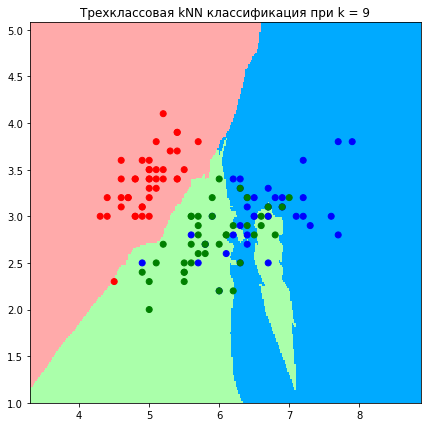

Accuracy: 73.33333333333333
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
Precision: 0.5
TP     FP
FN     TN
[[ 7  7]
 [ 1 15]]
Recall: 0.875
F-score: 0.6363636363636364


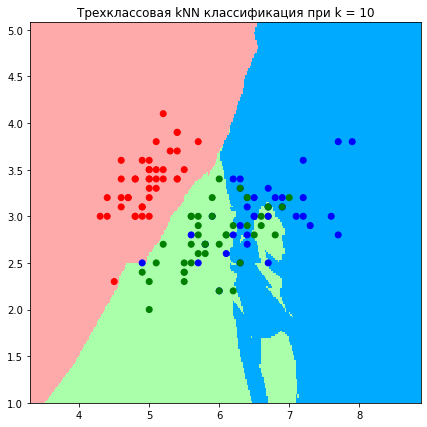

Accuracy: 80.0
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Precision: 0.5833333333333334
TP     FP
FN     TN
[[ 7  5]
 [ 1 17]]
Recall: 0.875
F-score: 0.7000000000000001


In [9]:
for k_ in range(1, 11):
    knn = KNN(X_train, y_train, X_test, y_test, k=k_, weight='distance')
    y_pred = knn.predict(pr_metric=True, plot=True)

В общем случае наблюдается тенденция к упрощению разделительной гиперплоскости при увеличении числа соседей(хотя, бывает, что и проскакивает усложнение в виде новых небольших островков, вероятность их появления тем выше, чем больше перемешаны классы).

Добавление весов по сложности гиперплоскости ситуацию в целом не меняет(при разных k то у одного алгоритма плоскость сложнее, то у другого), изменяеются только границы при равном количестве соседей.


За оптимальное значение в обоих видах добавления весов можно принять k = 2, при этом веса по дистанции до объекта дают более точный результат, но и на гиперплоскости последнего больше островов

<ipython-input-5-d62f8561e735>:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


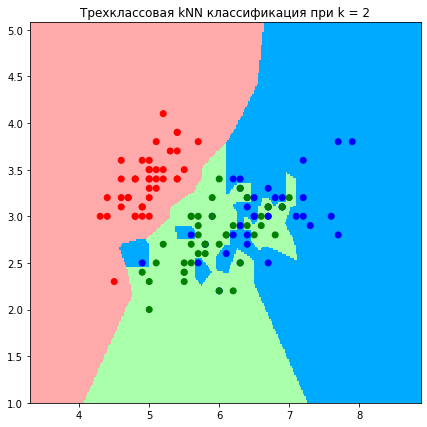

Accuracy: 83.33333333333333
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Precision: 0.6153846153846154
TP     FP
FN     TN
[[ 8  5]
 [ 0 17]]
Recall: 1.0
F-score: 0.761904761904762


In [10]:
knn = KNN(X_train, y_train, X_test, y_test, k=2, weight='i')
y_pred = knn.predict(pr_metric=True, plot=True)

<ipython-input-5-d62f8561e735>:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


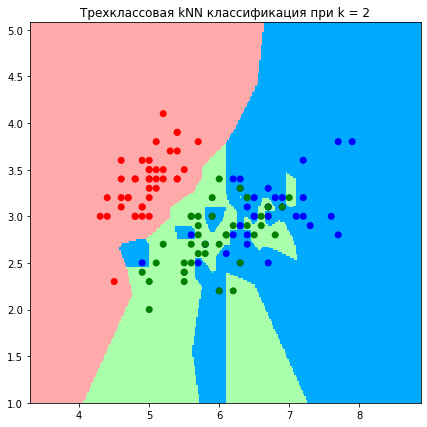

Accuracy: 90.0
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
Precision: 0.7272727272727273
TP     FP
FN     TN
[[ 8  3]
 [ 0 19]]
Recall: 1.0
F-score: 0.8421052631578948


In [11]:
knn = KNN(X_train, y_train, X_test, y_test, k=2, weight='distance')
y_pred = knn.predict(pr_metric=True, plot=True)

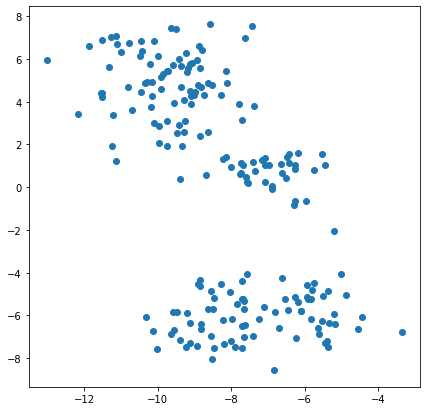

In [49]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=200, centers=5, random_state=633)

plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [19]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
      
    return np.sqrt(distance)

In [17]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [46]:
def visualize(centroids, classes, k):
    colors = ['pink', 'orange', 'yellow', 'brown', 'purple', '#8c7773', '#9faafa', 'r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    plt.title(f'K-means для {k} кластеров')
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()
    msd = round(msd_in_cluster(centroids, classes), 2)
    print(f'Среднее квадратичное внутриклассовое расстояние: {msd}')
    return msd

In [33]:
def msd_in_cluster(centroids, classes):
    msd = 0
    
    for class_item, centroid in zip(classes, centroids):
        sum_in_cluster = 0
        for x in classes[class_item]:
            sum_in_cluster += e_metrics(x, centroid) ** 2
        msd += sum_in_cluster
    
    return msd / len(centroids)

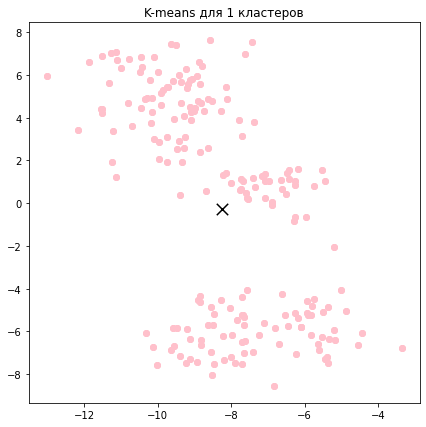

Среднее квадратичное внутриклассовое расстояние: 11676.36


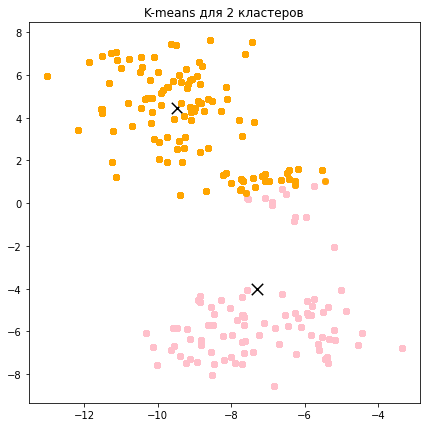

Среднее квадратичное внутриклассовое расстояние: 20435.71


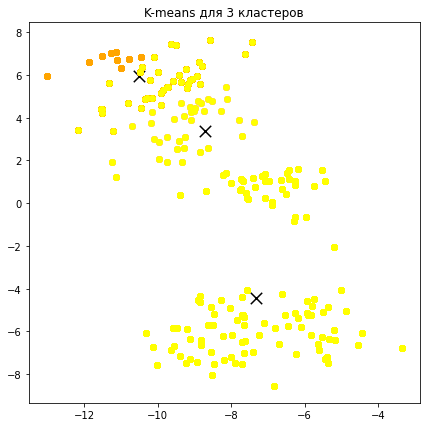

Среднее квадратичное внутриклассовое расстояние: 11564.94


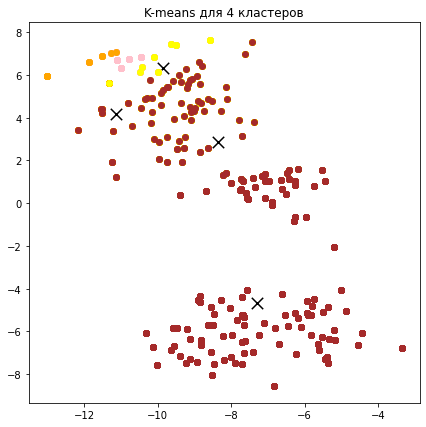

Среднее квадратичное внутриклассовое расстояние: 7465.98


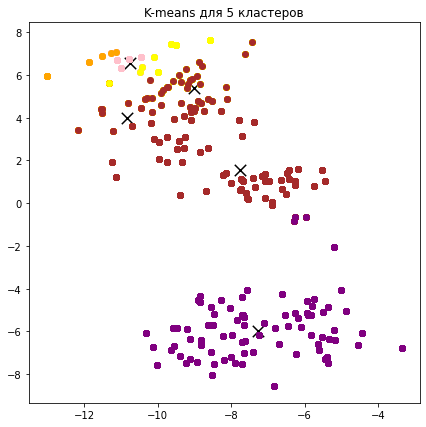

Среднее квадратичное внутриклассовое расстояние: 2389.86


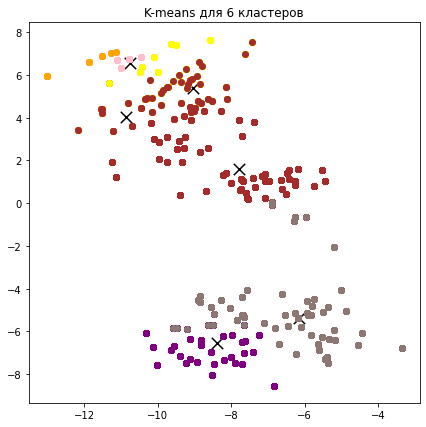

Среднее квадратичное внутриклассовое расстояние: 1598.9


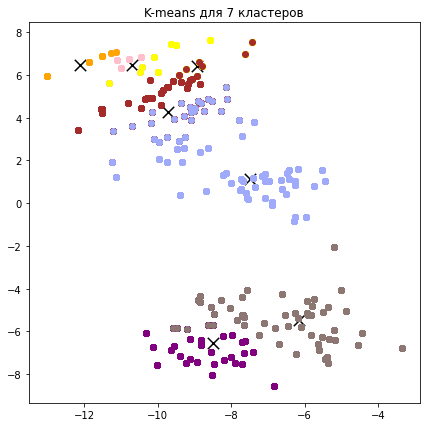

Среднее квадратичное внутриклассовое расстояние: 1134.76


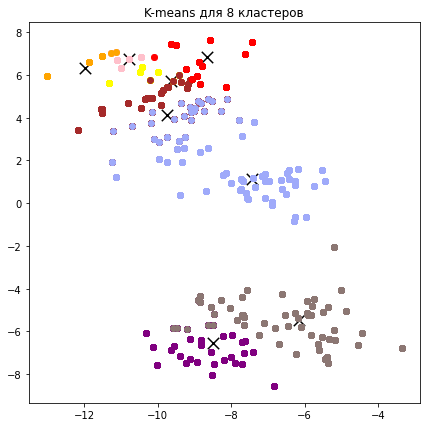

Среднее квадратичное внутриклассовое расстояние: 961.02


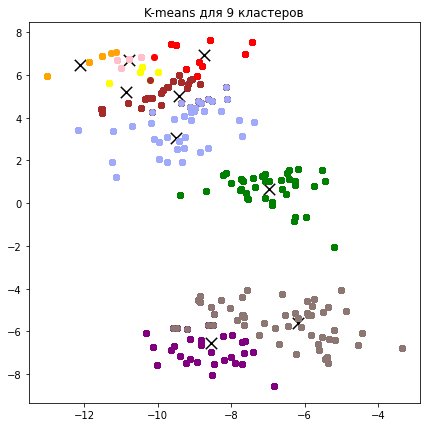

Среднее квадратичное внутриклассовое расстояние: 671.07


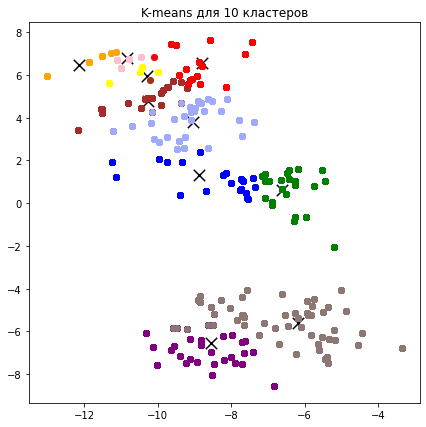

Среднее квадратичное внутриклассовое расстояние: 579.77


In [50]:
max_iterations = 20
min_distance = 1e-4
msd_list = []

k_list = range(1, 11)
for k in k_list:
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)

    msd = visualize(centroids, clusters, k)
    msd_list.append(msd)

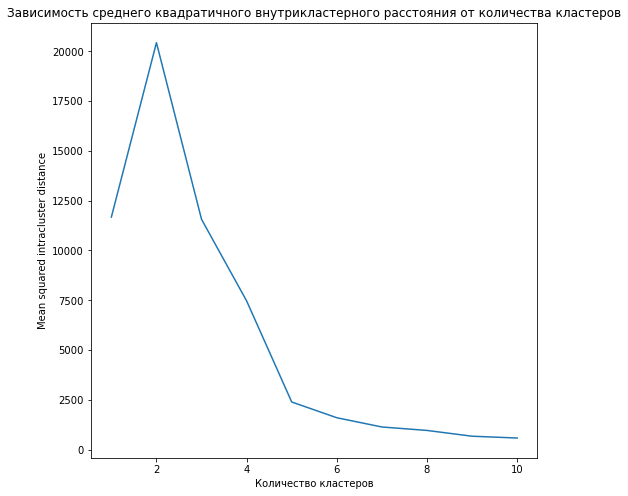

In [53]:
plt.figure(figsize=(8, 8))
plt.title('Зависимость среднего квадратичного внутрикластерного расстояния от количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Mean squared intracluster distance')
plt.plot(k_list, msd_list)

по графику можно сориентироваться, когда найдено оптимальное количество кластеров - когда закончилось резкое падение метрики (на "локте"), т.е. в данном случае 5 кластеров (как и было задано при генерации датасета)